# Estados Ligados

## Librerías

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from  scipy.special import laguerre, roots_laguerre


fs = 25
mpl.rcParams['legend.fontsize'] = fs
mpl.rcParams['axes.labelsize'] = fs
mpl.rcParams['xtick.labelsize'] = fs
mpl.rcParams['ytick.labelsize'] = fs
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'
mpl.rcParams.update({'font.size': fs})

## Scaled regularized Lagrange-Laguerre functions

In [28]:
def R_Lagrange_Laguerre(j, x, N, n, h=1):
    x_j = roots_laguerre(N)[0][j-1]
    #print(roots_laguerre(N)[0])
    f_j = ((-1)**j)*np.sqrt(x_j)*((x/x_j)**n)*laguerre(N)(x)*np.exp(-x/2)/(x-x_j)
    f_j /= np.sqrt(h)
    
    return f_j

In [29]:
N0 = 4
n = 1
x_0 = np.linspace(0, 200, int(5e3))
h = 1

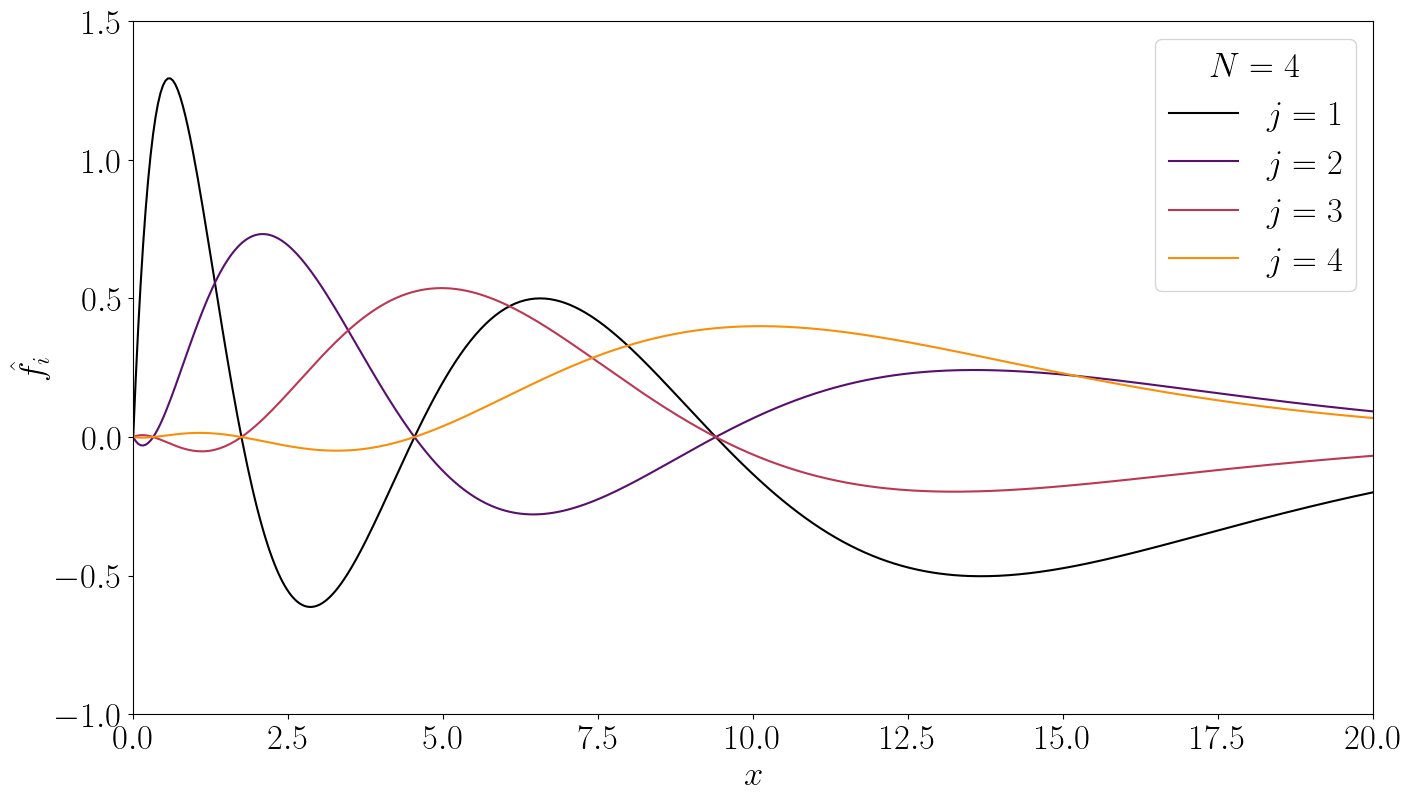

In [30]:
colors = plt.cm.inferno(np.linspace(0, 1, N0+1))

plt.figure(figsize = (16, 9))
for i in range(N0):
  x_r_i = x_0
  f_j = R_Lagrange_Laguerre(i+1, x_r_i, N0, n, h)
  plt.plot(x_r_i, f_j, color = colors[i], label = r'$j = %d$' %(i+1))
plt.xlim(0, 20)
plt.ylim(-1, 1.5)
plt.xlabel(r'$x$')
plt.ylabel(r'$\hat{f}_i$')
plt.legend(title = '$N = 4$')
plt.savefig('LL.pdf', format = 'PDF')

## Método Variacional

- Hallar energía del estado base del deuterio
- Dibujar función radial $u_0(r)$ utilizando el potencial:
\begin{equation}
  V_{np}(r) = 200 \exp(-1.487r^2) - 178 \exp(-0.639r^2)
\end{equation}
y las funciones anteriores
- Introduzca un factor de escalamiento $h$

**Sobre el método**
1. Para la ecuación de Schrödinger la función de onda puede expandirse en una base de lagrange de la forma
\begin{equation}
\psi(x) = \sum^N_{i=1}c_if_i(x)
\end{equation}
Donde los coeficientes son
\begin{equation}
c_i = \lambda_i^{1/2} \psi(x_i)
\end{equation}

Para un potencial central
\begin{equation}
  u_l(r) = \sum^N_{j=1} c_i \varphi_j(r)
\end{equation}

Donde en la ecuación de Schrödinger:
\begin{equation}
\dfrac{\partial}{\partial _ci} \left[ \left< \psi | (H - E) | \psi \right>\right] = \sum^N_{i = 1} \left< \varphi_i | H - \epsilon_i | \varphi_i \right>c_i = 0
\end{equation}

Para la matriz de energía cinética
\begin{equation}
T_{ij} = \left< f_i | T_l | f_i \right> = - \dfrac{\hbar^2}{2 \mu} \sqrt{\lambda_k} \dfrac{d^2}{d r^2} f_j (r_k)
\end{equation}

Para la matriz del potencial efectivo
\begin{equation}
V_{ij} = \left< f_i | V_{eff} | f_i \right> = - \dfrac{\hbar^2}{2 \mu} V_{eff}(r_i) \delta_{ij}
\end{equation}

Finalmente,
\begin{equation}
\sum^N_{j=1} c_j \left[ \frac{1}{h^{2}} T_{ij} + V_{eff}(x_i h) \delta_{ij}\right]  = E c_i
\end{equation}

En la base de Lagrange-Laguerre:
\begin{equation}
\hat{f_j} (x) = (-1)^j x_j^{1/2} \left( \frac{x}{x_j} \right)^n \dfrac{L_N(x)}{x - x_j} \exp \left(-\frac{x}{2} \right)
\end{equation}

Para la matriz de energía cinética
\begin{align}
\hat{T}_{i = j} = \dfrac{\hbar^2}{2 \mu} \dfrac{1}{12 x_i^2} \left[ 4 + (4N+2)x_i - x_i^2 \right]\\
\hat{T}_{i \neq j} = (-1)^{i-j} \dfrac{\hbar^2}{2 \mu} \dfrac{1}{(x_i x_j)^{1/2}} \dfrac{x_i+x_j}{(x_j-x_i)²}
\end{align}



In [31]:
def Potencial(r):
  return 200*np.exp(-1.487*r**2) - 178*np.exp(-0.639*r**2)

def delta_kronecker(i, j):
  if i == j:
    r = 1
  else:
    r = 0
  return r

def Vij(mu, r, i, j):
  return Potencial(r)*delta_kronecker(i, j)

def Tij(x, i, j, N):
  if i==j:
    T_ij = (1/(12*((x[i])**2)))*(4+(4*N+2)*x[i]-((x[i])**2))
  else:
    T_ij = ((-1)**(i-j))*(1/(np.sqrt(x[i]*x[j])))*((x[i]+x[j])/((x[i]-x[j])**2))
  return T_ij

def T(mu, N):
  #hbar*c = 197 MeV fm
  C = (197**2)/(2*mu)
  T_M = np.zeros((N, N))
  x = roots_laguerre(N)[0]
  for i in range(N):
    for j in range(N):
      T_M[i, j] = C*Tij(x, i, j, N)
  return T_M

def V(mu, N, h):
  V_M = np.zeros((N, N))
  r = roots_laguerre(N)[0]*h
  for i in range(N):
    for j in range(N):
      V_M[i, j] = Vij(mu, r[i], i, j)
  return V_M

def EigenVals(M):
  return np.linalg.eig(M)

def Projection(mu, N, h):
  TM = T(mu, N)
  VM = V(mu, N, h)

  #V_diag = np.eye(N)*np.diag(VM)
  M = (TM/(h**2)) + VM

  lambda_i, auto_vec_i = EigenVals(M)

  return M, lambda_i, auto_vec_i

### Potencial

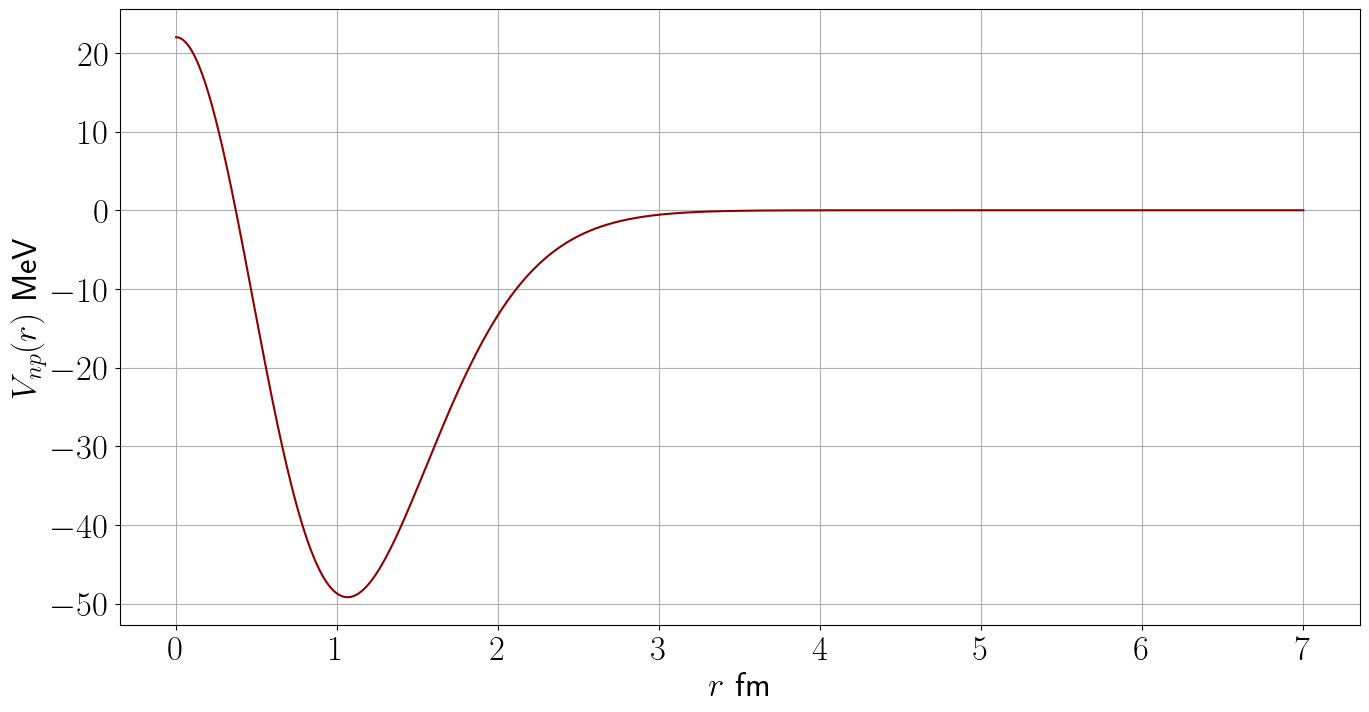

In [32]:
x_V = np.linspace(0, 7, 1000)
V_V = Potencial(x_V)

plt.figure(figsize = (16, 8))
plt.plot(x_V, V_V, color = 'darkred')
plt.xlabel(r'$r$ fm')
plt.ylabel(r'$V_{np}(r)$ MeV')
plt.grid()
plt.savefig('Vnp.pdf', format = 'PDF')

### Caso de Estudio: Energía del estado base del deuterio

Reacción:
\begin{equation}
P + n \rightarrow D
\end{equation}

Para la masa reducida
\begin{equation}
\mu = \dfrac{m_P \cdot m_n}{m_P+m_n}
\end{equation}


In [33]:
m_P = 938.3 #MeV/c²
m_n = 939.6 #MeV/c²

mu = m_P*m_n/(m_P + m_n)
print(mu, " MeV")

469.47477501464397  MeV


In [59]:
N = 60
n = 1
x_0 = np.linspace(0, 50, int(5e3))
h = 0.5

In [60]:
H, lambda_i, auto_vec_i= Projection(mu, N, h)

In [61]:
P = auto_vec_i
P_Inv = np.linalg.inv(P)
E = np.linalg.multi_dot([P_Inv, H, P])

In [62]:
#Energía del estado base:
print(r'$E_0$ = ', np.min(lambda_i), 'MeV')

$E_0$ =  -2.2372338910618894 MeV


In [63]:
#Funciones de Onda
index = np.argsort(lambda_i)[0]

print('Energía del estado base:')
E0 = lambda_i[index]
print(E0)
print('Coeficientes:')
C_0 = auto_vec_i[:, index]
print(C_0)

Energía del estado base:
-2.2372338910618894
Coeficientes:
[ 9.77024968e-04  7.85931155e-03  2.42682930e-02  5.28865913e-02
  9.60105556e-02  1.54207147e-01  2.22283929e-01  2.85946837e-01
  3.28009276e-01  3.42011460e-01  3.34915922e-01  3.16863404e-01
  2.94041504e-01  2.69045070e-01  2.43048168e-01  2.16854670e-01
  1.91131873e-01  1.66431430e-01  1.43187189e-01  1.21716712e-01
  1.02227714e-01  8.48282346e-02  6.95398923e-02  5.63125879e-02
  4.50401584e-02  3.55754560e-02  2.77446930e-02  2.13598700e-02
  1.62295471e-02  1.21671613e-02  8.99751030e-03  6.56090958e-03
  4.71586832e-03  3.33995688e-03  2.32978975e-03  1.59983107e-03
  1.08091273e-03  7.18120381e-04  4.68844583e-04  3.00566042e-04
  1.89069797e-04  1.16575618e-04  7.03989705e-05  4.15719855e-05
  2.39917002e-05  1.34933781e-05  7.39997253e-06  3.93214960e-06
  2.03624517e-06  1.00819888e-06  4.91677151e-07  2.18939122e-07
  1.03907252e-07  3.52786755e-08  2.20517290e-08 -7.61526727e-10
  9.11685780e-09 -7.83739424e-0

In [68]:
Check = np.matmul(H, C_0)
Check_2 = E0*C_0

print(Check)
print("\n")
print(Check_2)

[-2.18583337e-03 -1.75831182e-02 -5.42938476e-02 -1.18319674e-01
 -2.14798069e-01 -3.44997455e-01 -4.97301140e-01 -6.39729955e-01
 -7.33833469e-01 -7.65159629e-01 -7.49285252e-01 -7.08897546e-01
 -6.57839617e-01 -6.01916748e-01 -5.43755599e-01 -4.85154616e-01
 -4.27606704e-01 -3.72346037e-01 -3.20343232e-01 -2.72308754e-01
 -2.28707306e-01 -1.89780601e-01 -1.55577004e-01 -1.25984430e-01
 -1.00765369e-01 -7.95906158e-02 -6.20713675e-02 -4.77870250e-02
 -3.63092928e-02 -2.72207855e-02 -2.01295350e-02 -1.46782893e-02
 -1.05505004e-02 -7.47226472e-03 -5.21228458e-03 -3.57919630e-03
 -2.41825459e-03 -1.60660325e-03 -1.04891499e-03 -6.72436535e-04
 -4.22993358e-04 -2.60806924e-04 -1.57498963e-04 -9.30062548e-05
 -5.36750447e-05 -3.01878427e-05 -1.65554693e-05 -8.79713835e-06
 -4.55555671e-06 -2.25557671e-06 -1.09999679e-06 -4.89818025e-07
 -2.32464823e-07 -7.89266505e-08 -4.93348752e-08  1.70371448e-09
 -2.03965427e-08  1.75340829e-08 -2.26048578e-08  4.07325744e-08]


[-2.18583337e-03 -1.75

### Función de Onda Radial

\begin{equation}
u_0(r) = \sum^N_j c_j \hat{f}_j
\end{equation}

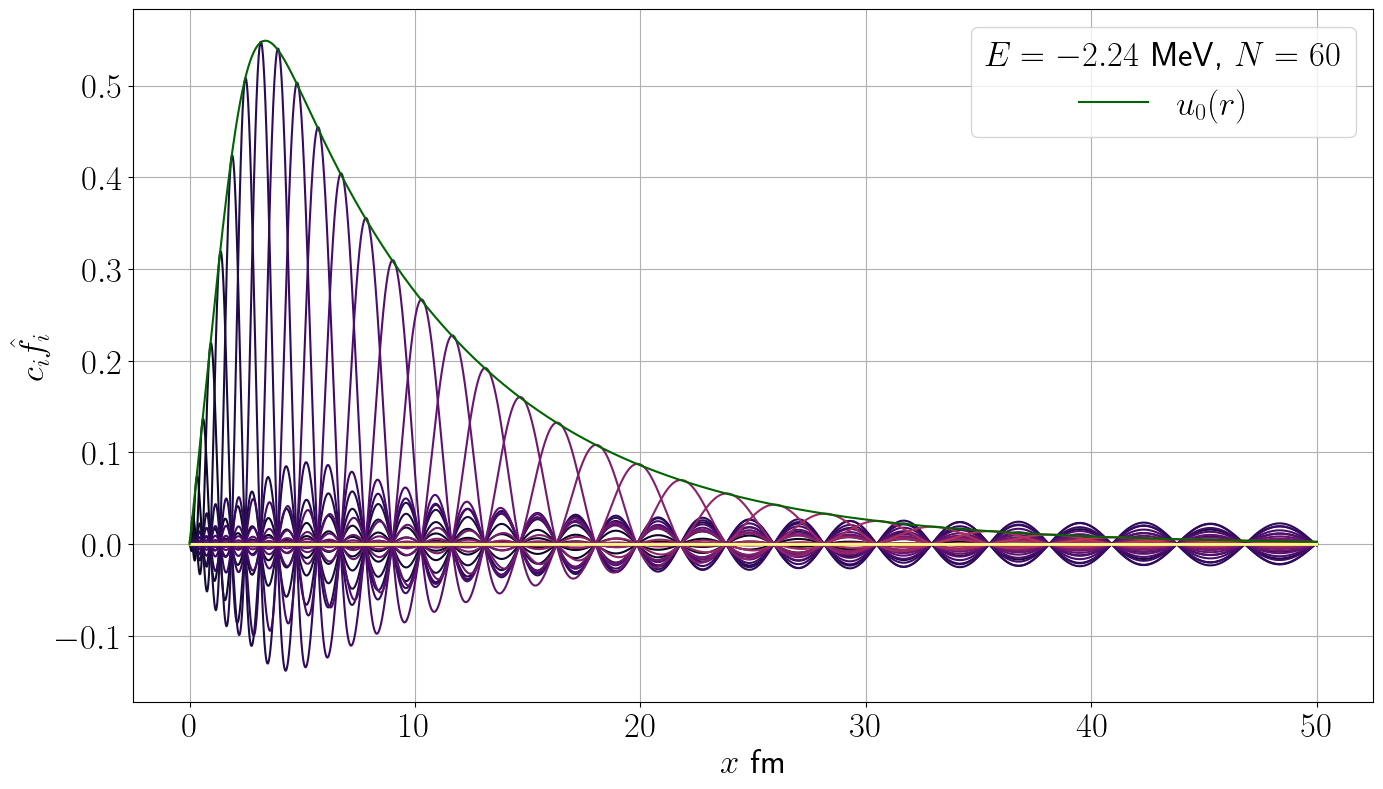

In [65]:
#Solución de la ecuación de Onda Radial
u_r = 0
colores = plt.cm.inferno(np.linspace(0, 1, N+2))

plt.figure(figsize = (16, 9))
for i in range(N):
  f_j = R_Lagrange_Laguerre(i+1, x_0, N, n, h)
  u_r += C_0[i]*f_j
  plt.plot(x_0, C_0[i]*f_j, color = colores[i+1])
  #plt.plot(x_0, C_0[i]*f_j, color = colores[i+1], label = r'$j = $ %d, $c_%.d = $ %.3f' %(i+1, i+1, C_0[i]))

plt.plot(x_0, u_r, color = 'darkgreen', label = r'$u_0(r)$')
plt.grid()
plt.xlabel(r'$x$ fm')
plt.ylabel(r'$c_i \hat{f}_i$')
plt.legend(title = r'$E = %.2f$ MeV, $N = %d$' %(E0, N))
plt.savefig('u0.pdf', format = 'PDF')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


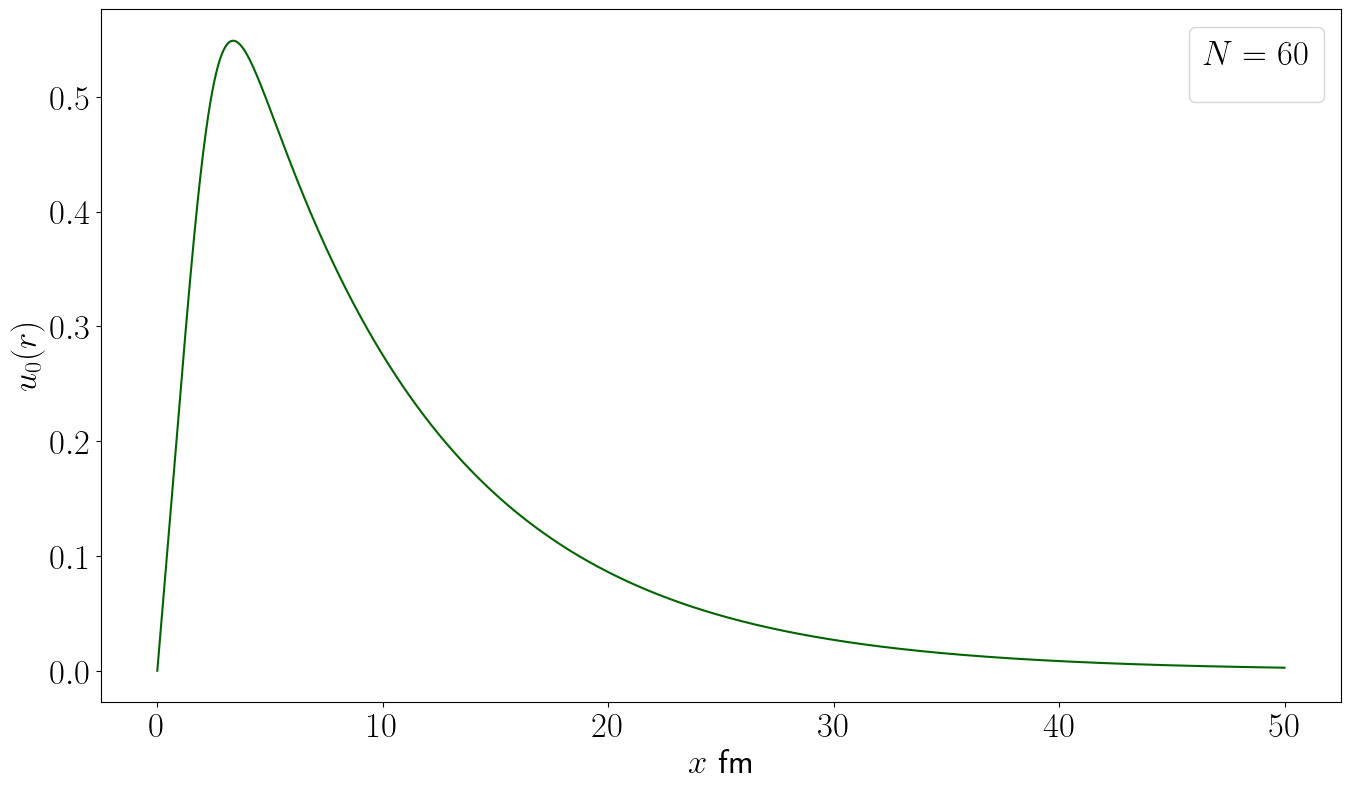

In [66]:
plt.figure(figsize = (16, 9))
plt.plot(x_0, u_r, color = 'darkgreen')
plt.xlabel(r'$x$ fm')
plt.ylabel(r'$u_0(r)$')
plt.legend(title = r'$N = %d$' %(N))
plt.show()

### $E_0$ vs N

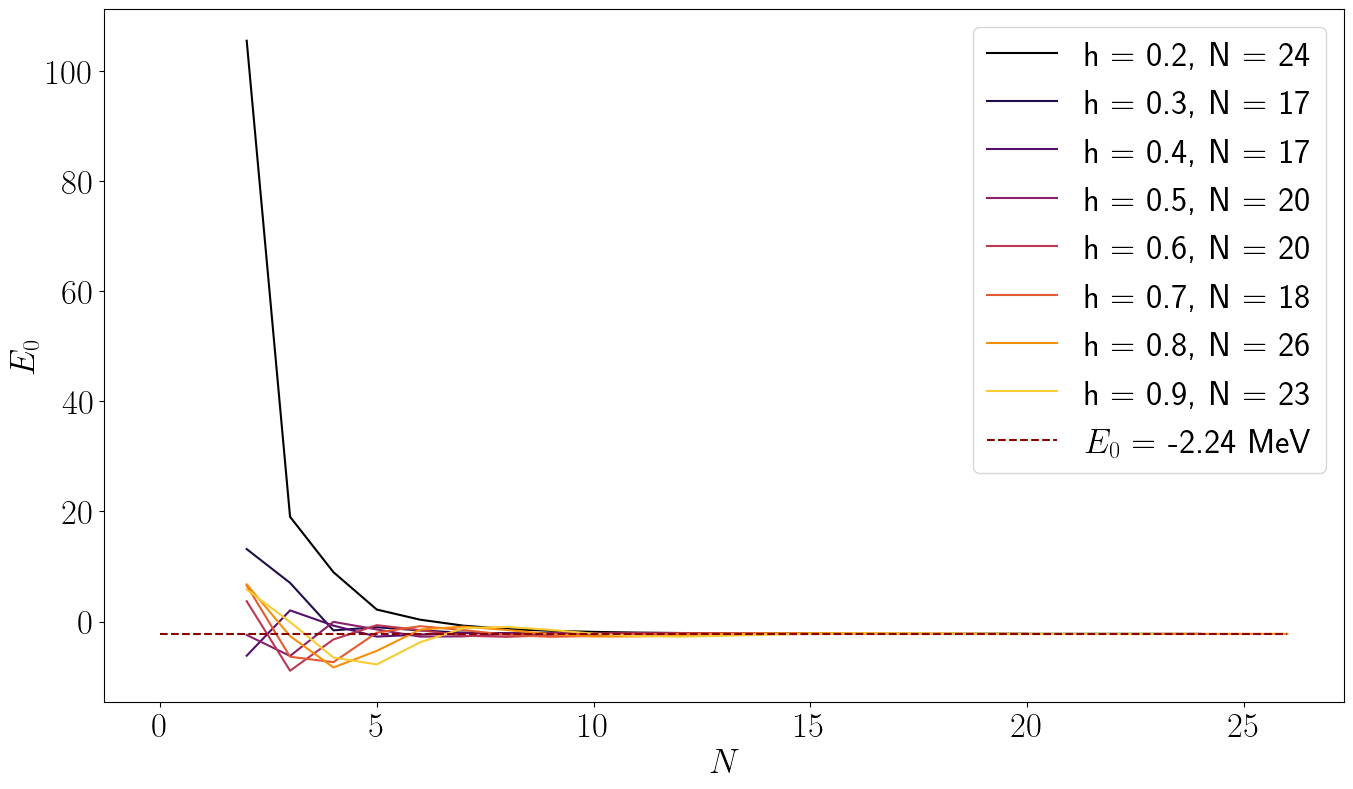

In [42]:
N_0 = 2
N_vals = np.array([])
h_vals = np.arange(0.2, 1, 0.1)
E_vals = np.array([])
E_prev = 0
E_new = 1
Ediff = 1

colores = plt.cm.inferno(np.linspace(0, 1, len(h_vals)+1))

plt.figure(figsize = (16, 9))
for i in range(len(h_vals)):
    while(Ediff>1e-3):
        E_prev = E_new
        N_vals = np.append(N_vals, N_0)
        H, lambda_i, auto_vec_i= Projection(mu, N_0, h_vals[i])
        E_new = np.min(lambda_i)
        E_vals = np.append(E_vals, E_new)
        Ediff = np.abs(E_new - E_prev)
        #print(N_0, E_new, Ediff)
        N_0+=1
    plt.plot(N_vals, E_vals, color = colores[i], label = 'h = %.1f, N = %d' %(h_vals[i], N_0-1))
    N_vals = np.array([])
    E_vals = np.array([])
    E_prev = 0
    E_new = 1
    Ediff = 1
    N_0 = 2
plt.hlines(y = -2.24, xmin = 0, xmax = 26, color = 'darkred',ls = 'dashed', label = r'$E_0$ = -2.24 MeV')
plt.xlabel(r'$N$')
plt.ylabel(r'$E_0$')
plt.legend()
plt.savefig('E0vsN.pdf', format = 'PDF')
